running for the data set iris
for random 20 sample data vectors
Schmidt threshold:0.3
Schmidt terms: 1
ancilla qubits: 0
ancilla layers: 1
data qubits: 2
0: ─╭|Ψ⟩──RY─┤ ╭Probs
1: ─╰|Ψ⟩──RY─┤ ╰Probs
Epoch   0 | Loss: 0.0940 | Best 0.0940
Epoch   5 | Loss: 0.0872 | Best 0.0872
Epoch  10 | Loss: 0.0803 | Best 0.0803
Epoch  15 | Loss: 0.0732 | Best 0.0732
Epoch  20 | Loss: 0.0660 | Best 0.0660
Epoch  25 | Loss: 0.0586 | Best 0.0586
Epoch  30 | Loss: 0.0511 | Best 0.0511
Epoch  35 | Loss: 0.0436 | Best 0.0436
Epoch  40 | Loss: 0.0361 | Best 0.0361
Epoch  45 | Loss: 0.0288 | Best 0.0288
Epoch  50 | Loss: 0.0219 | Best 0.0219
Epoch  55 | Loss: 0.0155 | Best 0.0155
Epoch  60 | Loss: 0.0104 | Best 0.0104
Epoch  65 | Loss: 0.0074 | Best 0.0074
Epoch  70 | Loss: 0.0067 | Best 0.0067
Epoch  75 | Loss: 0.0066 | Best 0.0066
Epoch  80 | Loss: 0.0064 | Best 0.0064
Epoch  85 | Loss: 0.0063 | Best 0.0063
Epoch  90 | Loss: 0.0062 | Best 0.0062
Epoch  95 | Loss: 0.0061 | Best 0.0061
Epoch 100 | Loss: 0.00

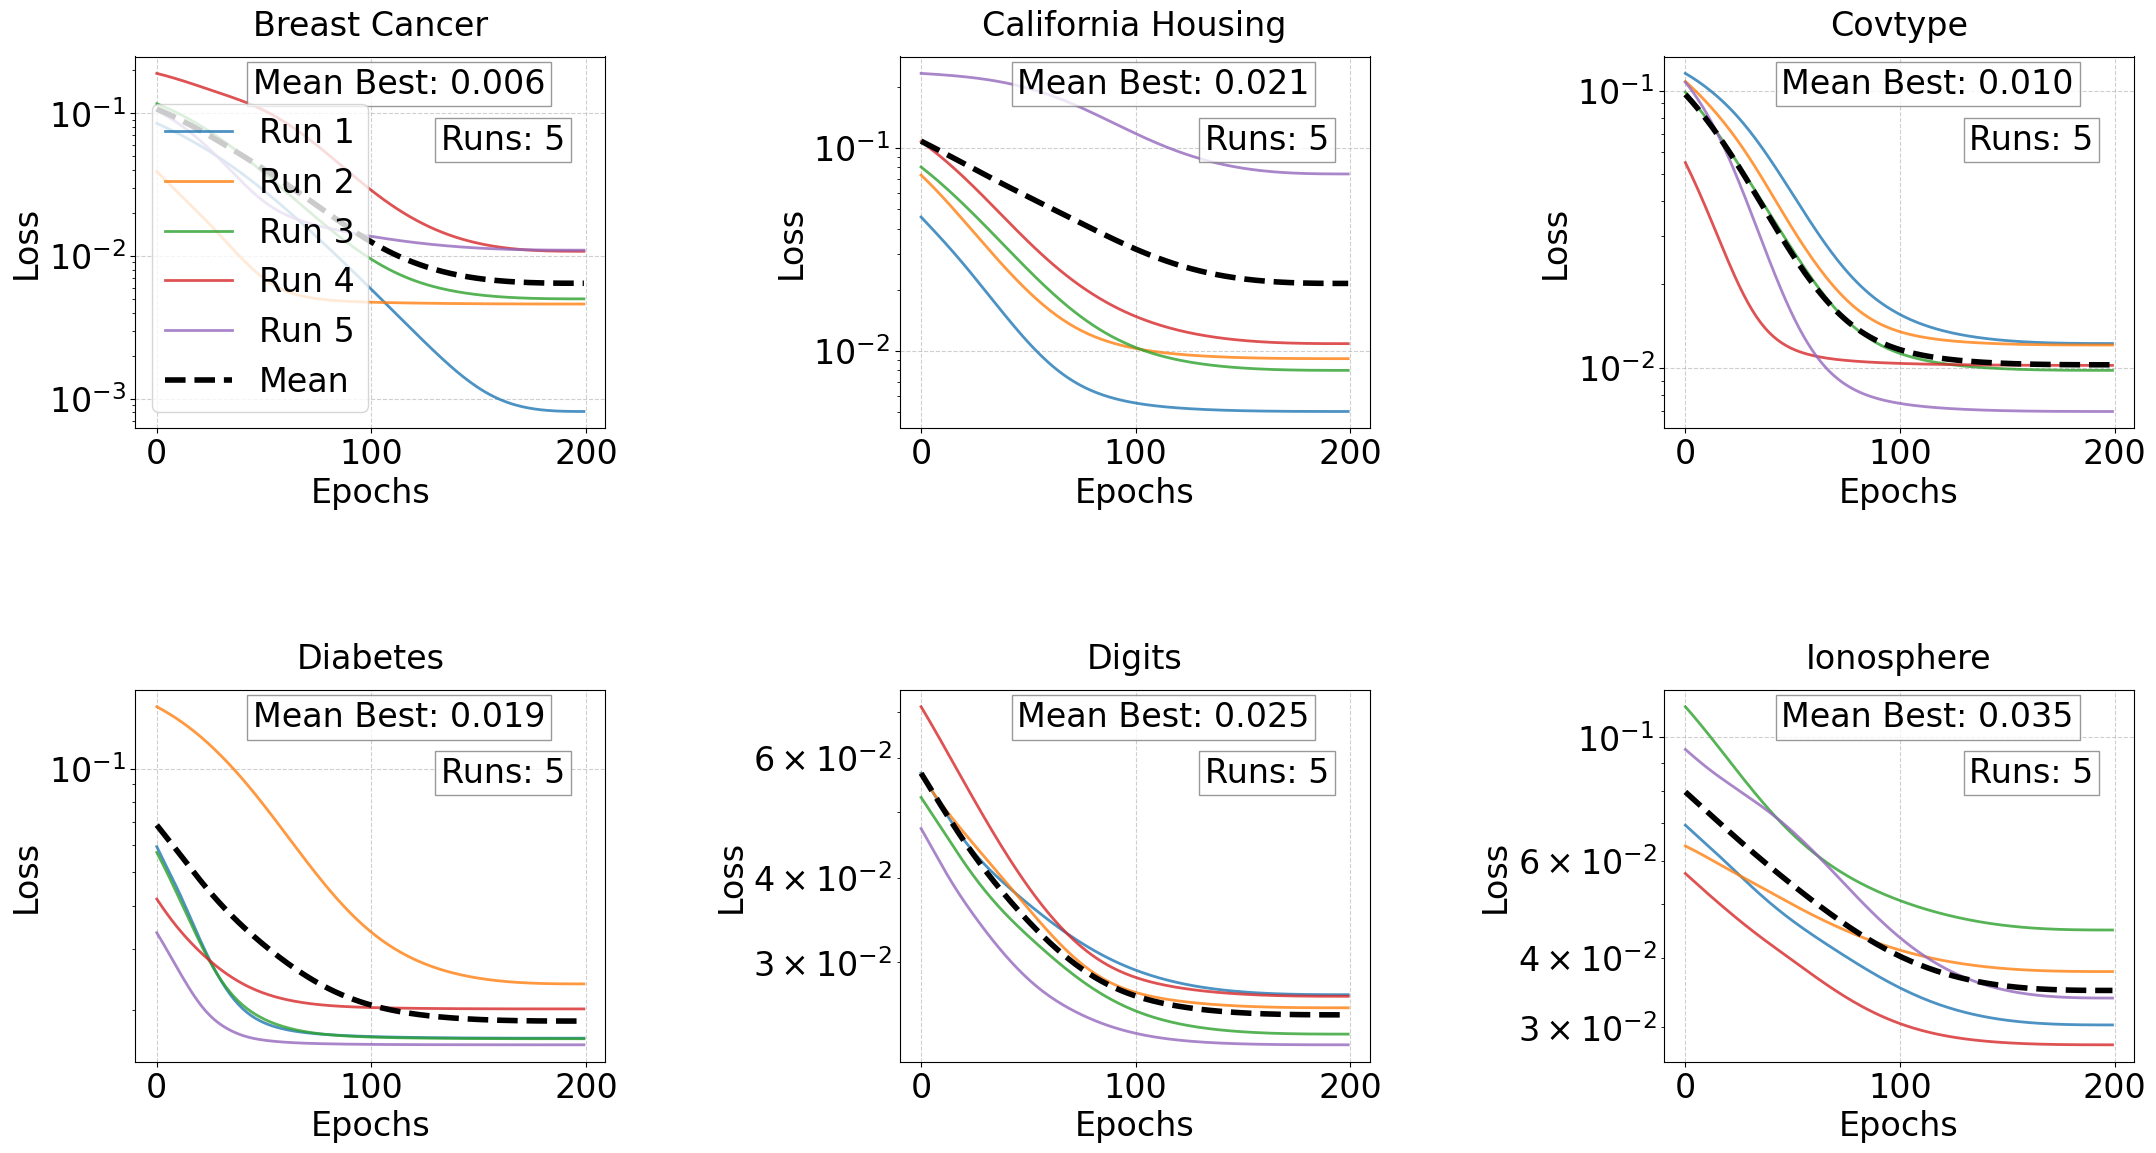

In [ ]:
import pennylane as qml
import numpy as np
from math import ceil, log2
import torch
import torch.nn as nn
from schmidt_decomposition import SchmidtDecomposition, number_of_terms_above_threshold


# -----------------------------------------------------------------------------
# 2) Quantum circuit module with probs optimization
# -----------------------------------------------------------------------------
class SchmidtQuantumCircuit(nn.Module):
    def __init__(
        self,
        n_qubits: int,
        n_terms: int,
        init_terms: list = None,
        n_ancilla_layers: int = 2,
    ):
        super().__init__()
        self.n_qubits = n_qubits
        self.n_terms = n_terms
        self.n_ancilla = ceil(log2(n_terms)) if n_terms > 1 else 0
        self.n_ancilla_layers = n_ancilla_layers

        # Ancilla rotation parameters
        if self.n_ancilla > 0:
            num_ancilla_params = self.n_ancilla + max(0, self.n_ancilla - 1)
            self.ancilla_params = nn.Parameter(
                torch.randn(self.n_ancilla_layers * num_ancilla_params)
            )
        else:
            self.ancilla_params = None

        # Data-qubit parameters - now with optional Schmidt initialization
        self.unitary_params = nn.ParameterList()

        # # Initialize from Schmidt decomposition if provided
        # # We did not observe any performance improvement from this!
        # # maybe the angle computations for also coefficients would make better!
        # if init_terms:

        #     for k in range(min(n_terms, len(init_terms))):
        #         term_angles = []
        #         for vector in init_terms[k]:
        #             angle = SchmidtDecomposition.vector_to_angle(vector)
        #             term_angles.append(angle)
        #         # Initialize parameter with Schmidt-derived angles
        #         self.unitary_params.append(
        #             nn.Parameter(torch.tensor(term_angles, dtype=torch.float32)))

        #     # Initialize remaining terms randomly
        #     for _ in range(n_terms - len(init_terms)):
        #         print("herrrrr")
        #         self.unitary_params.append(
        #             nn.Parameter(torch.randn(self.n_qubits)))
        # else:
        # All random initialization
        for _ in range(n_terms):
            self.unitary_params.append(nn.Parameter(torch.randn(self.n_qubits)))

        self.dev = qml.device("lightning.qubit", wires=self.n_ancilla + self.n_qubits)
        self.qnode = self.create_qnode()

    def create_qnode(self):
        @qml.qnode(self.dev, interface="torch")
        def circuit(features):
            # Ancilla preparation
            if self.n_ancilla > 0:
                p = 0
                for l in range(self.n_ancilla_layers):
                    for i in range(self.n_ancilla):
                        qml.RY(self.ancilla_params[p], wires=i)
                        p += 1
                    for i in range(self.n_ancilla - 1):
                        qml.CRY(self.ancilla_params[p], wires=[i, i + 1])
                        p += 1

            # Embed input data
            data_wires = list(range(self.n_ancilla, self.n_ancilla + self.n_qubits))
            qml.AmplitudeEmbedding(features=features, wires=data_wires, normalize=True)

            # Apply parameterized unitaries
            ctrl_qubits = list(range(self.n_ancilla))
            if self.n_ancilla == 0:
                for q in range(self.n_qubits):
                    qml.RY(self.unitary_params[0][q], wires=q + self.n_ancilla)
            else:
                for k in range(self.n_terms):
                    ctrl_bin_values = bin(k)[2:].zfill(self.n_ancilla)
                    ctrl_int_values = [int(a) for a in list(ctrl_bin_values)]
                    for q in range(self.n_qubits):
                        qml.ctrl(qml.RY, ctrl_qubits, control_values=ctrl_int_values)(
                            self.unitary_params[k][q], wires=q + self.n_ancilla
                        )

            return qml.probs(data_wires)

        return circuit

    def forward(self, x: torch.Tensor):
        return self.qnode(x)


# -----------------------------------------------------------------------------
def visualize_circuit(model, avector):
    """Visualize the quantum circuit"""
    fig, ax = qml.draw_mpl(model.qnode, show_all_wires=True)(avector)
    # plt.title("")
    plt.tight_layout()
    plt.show()


# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------
# 3) Optimization Framework
# -----------------------------------------------------------------------------
def optimize_schmidt_circuit(
    data: np.ndarray,
    schmidt_threshold=0.1,
    epochs=100,
    lr=0.01,
    single_vector=False,  # run for single or multiple vectors
    min_terms=1 #number of minimum terms
):
    """Optimizes quantum circuit to match Schmidt decomposition targets"""

    sd = SchmidtDecomposition(threshold=schmidt_threshold)

    if data.ndim == 1 or single_vector == True:
        single_vector = True
        n_qubits = int(log2(data.size))
        # Precompute target Schmidt states
        data = data / np.linalg.norm(data)  # normalize data
        mean_vec = data
        target_probs = np.abs(sd.compute_decomposition(mean_vec)) ** 2
        target_probs = torch.Tensor(target_probs).float()
        # Get initial circuit parameters from data vector
        terms, _ = sd.flatten_decomposition(mean_vec)
    else:
        single_vector = False
        n_qubits = int(log2(len(data[0])))
        # Precompute target Schmidt states
        target_probs = []
        for vec in data:
            vec_norm = np.linalg.norm(vec)
            if vec_norm == 0:
                print("⚠️Warning: Data vector has zero norm! it is converted to 1..00")
                vec[0] = 1
            else:
                vec = vec / vec_norm  # normalize vector

          
            target = np.abs(sd.compute_decomposition(vec)) ** 2
            target_probs.append(torch.tensor(target))

        target_probs = torch.stack(target_probs)
        # Get initial circuit parameters from mean vector
        mean_vec = data.mean(axis=0)
        mean_vec = mean_vec / np.linalg.norm(mean_vec)
        terms, _ = sd.flatten_decomposition(mean_vec)

    n_terms = len(terms)
    if n_terms == 1:
        n_terms = min_terms
    model = SchmidtQuantumCircuit(
        n_qubits, n_terms, init_terms=None, n_ancilla_layers=(n_terms + 1) // 2
    )

    print(
        f"Schmidt threshold:{sd.threshold}\n"
        f"Schmidt terms: {n_terms}\n"
        f"ancilla qubits: {model.n_ancilla}\n"
        f"ancilla layers: {model.n_ancilla_layers}\n"
        f"data qubits: {n_qubits}"
    )
    # visualize_circuit(model, mean_vec)
    print(qml.draw(model.qnode, decimals=None)(mean_vec))

    # Optimization setup
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    best_loss = 2**n_qubits
    best_output_probs = []
    losses = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        if single_vector:
            # Compute circuit output
            output_probs = model(torch.tensor(data)).float()
            loss = norm_of_prob_diffs(output_probs, target_probs)
        else:
            # Compute circuit outputs
            output_probs = []
            for sample in data:
                output = model(torch.tensor(sample, dtype=torch.float32))
                output_probs.append(output)

            output_probs = torch.stack(output_probs)


            loss = average_norm_of_prob_diffs(output_probs, target_probs)

        # Backpropagation
        loss.backward()
        optimizer.step()
        scheduler.step()

        # Track best fidelity
        if loss.item() < best_loss:
            best_loss = loss.item()
            best_output_probs = output_probs

        if epoch % 5 == 0:
            print(f"Epoch {epoch:3d} | Loss: {loss.item():.4f} | Best {best_loss:.4f}")

        losses.append(loss.item())

    print(f"\nOptimization Complete | Best Loss: {best_loss:.4f}")
    print("found", torch.round(best_output_probs, decimals=2))
    print("target", torch.round(target_probs, decimals=2))
    return (
        model,
        best_loss,
        losses,
    )

def mse_loss(probs1: torch.Tensor, probs2: torch.Tensor):
    """Compute MSE between two probability tensors"""
    return torch.mean((probs1 - probs2)**2)
    
def norm_of_prob_diffs(probs1: torch.Tensor, probs2: torch.Tensor):
    """Compute average state fidelity between two states"""
    return torch.norm((probs1 - probs2),'fro')


def average_norm_of_prob_diffs(probs1: torch.Tensor, probs2: torch.Tensor):
    """Compute average state fidelity between two sets of state vectors"""
    return torch.norm((probs1 - probs2),'fro') / len(probs1)


#####################################################3
######################### the below is for running###
def random_data(n_qubits, dist="normal"):
    import numpy as np

    n = n_qubits
    N = 2**n
    dist = "normal"
    rng = np.random.default_rng()
    if dist == "normal":
        x = rng.normal(size=N)
    elif dist == "uniform":
        x = rng.uniform(size=N)
    elif dist == "exponential":
        x = rng.exponential(size=N)
    elif dist == "poisson":
        x = rng.poisson(size=N)
    return x


def run_for_single_vector(n_qubits=3, n_runs=100):
    all_results = {}
    for i in range(n_runs):
        avec = random_data(n_qubits)
        avec = avec / np.linalg.norm(avec)
        qc, best_loss, _ = optimize_schmidt_circuit(
            avec, schmidt_threshold=0.05, epochs=100, lr=0.01
        )
        all_results[i] = best_loss

    return all_results


def run_for_mean_data_vectors(number_of_runs=1,datasets=None):
    from data_loaders import load_dataset
    if datasets is None:
        datasets = ["iris",]
    all_results = {}
    sample_size = 50
    for ds in datasets:
        print("=" * 40)
        print(
            f"running for the data set {ds}\n"
            f"for random {sample_size} sample data vectors"
        )
        X, y, n_qubits, n_classes = load_dataset(ds)

        average_loss = 0
        for i in range(number_of_runs):
            sample_indices = np.random.choice(
                len(X), size=min(sample_size, len(X)), replace=False
            )
            mean_vec = X.mean(axis=0)
            mean_vec = mean_vec / np.linalg.norm(mean_vec)
            qc, best_loss, losses = optimize_schmidt_circuit(
                mean_vec, schmidt_threshold=0.3, epochs=200, lr=0.01
            )
            all_results[ds + f"-{i}"] = (best_loss, losses)
            average_loss += best_loss
        print(f"the final average loss for {ds} is { average_loss/number_of_runs}\n")
        print("=" * 40)

    print(all_results)
    return all_results


def run_for_data_samples(number_of_runs=1, sample_size=20,datasets=None):
    from data_loaders import load_dataset
    if datasets is None:
        datasets = ["iris",]
    all_results = {}
    sample_size = sample_size
    for ds in datasets:
        print("=" * 40)
        print(
            f"running for the data set {ds}\n"
            f"for random {sample_size} sample data vectors"
        )
        X, y, n_qubits, n_classes = load_dataset(ds)

        average_loss = 0
        for i in range(number_of_runs):
            sample_indices = np.random.choice(
                len(X), size=min(sample_size, len(X)), replace=False
            )

            qc, best_loss, losses = optimize_schmidt_circuit(
                X[sample_indices], schmidt_threshold=0.3, epochs=200, lr=0.01
            )
            all_results[ds + f"-{i}"] = (best_loss, losses)
            average_loss += best_loss
        print(f"the final average loss for {ds} is { average_loss/number_of_runs}\n")
        print("=" * 40)

    print(all_results)
    return all_results


# %%


def plot_results(all_results, number_of_runs=5, fig_name="loss_curves"):
    from matplotlib import pyplot as plt
    import numpy as np
    import matplotlib as mpl

    # Configure global font settings
    mpl.rcParams.update(
        {
            "font.size": 24,
            "axes.titlesize": 24,
            "axes.labelsize": 24,
            "xtick.labelsize": 24,
            "ytick.labelsize": 24,
            "legend.fontsize": 24,
        }
    )

    # Extract dataset names (unique base names without run index)
    base_datasets = sorted({k.split("-")[0] for k in all_results.keys()})

    # Create 2x3 subplot grid
    fig, axs = plt.subplots(2, 3, figsize=(24, 14))
    axs = axs.flatten()

    for i, dataset in enumerate(base_datasets):
        if i >= 6:  # Only plot first 6 datasets
            break

        ax = axs[i]
        dataset_losses = []
        best_losses = []

        # Collect all runs for this dataset
        for run_idx in range(number_of_runs):
            key = f"{dataset}-{run_idx}"
            if key in all_results:
                best_loss, losses = all_results[key]
                dataset_losses.append(losses)
                best_losses.append(best_loss)

        if not dataset_losses:
            continue

        # Calculate mean values
        mean_best = np.mean(best_losses)
        mean_loss = np.mean(dataset_losses, axis=0)
        epochs = len(mean_loss)

        # Plot individual runs
        for j, loss_curve in enumerate(dataset_losses):
            ax.plot(
                loss_curve,
                # color='gray',
                alpha=0.8,
                linewidth=2,
                label=f"Run {j+1}" if i == 0 else None,
            )

        # Plot mean curve
        ax.plot(
            mean_loss,
            "--",
            color="black",
            linewidth=4,
            label="Mean" if i == 0 else None,
        )

        # Add annotations
        ax.text(
            0.25,
            0.90,
            f"Mean Best: {mean_best:.3f}",
            transform=ax.transAxes,
            fontsize=24,
            bbox=dict(facecolor="white", alpha=0.8, edgecolor="gray"),
        )

        ax.text(
            0.65,
            0.75,
            f"Runs: {len(dataset_losses)}",
            transform=ax.transAxes,
            fontsize=24,
            bbox=dict(facecolor="white", alpha=0.8, edgecolor="gray"),
        )

        # Configure plot appearance
        ax.set_title(f"{dataset.replace('_', ' ').title()}", fontsize=24, pad=15)
        ax.set_xlabel("Epochs", fontsize=24)
        ax.set_ylabel("Loss", fontsize=24)
        ax.grid(True, linestyle="--", alpha=0.6)
        ax.set_yscale("log")  # Logarithmic scale often helps visualize loss

        # Only add legend to first plot
        if i == 0:
            ax.legend(loc="lower left", framealpha=0.8)

    # Handle any empty subplots
    for j in range(i + 1, 6):
        axs[j].axis("off")

    # Adjust layout
    plt.tight_layout(pad=4.0, w_pad=3.0, h_pad=4.0)

    # Save high-resolution figures
    plt.savefig(f"{fig_name}.pdf", dpi=300, bbox_inches="tight")
    plt.savefig(f"{fig_name}.png", dpi=300, bbox_inches="tight")
    plt.show()
    plt.close()


# if __name__ == "__main__":
    # qc, best_loss, losses = optimize_schmidt_circuit(
    #     X[sample_indices], schmidt_threshold=0.3, epochs=200, lr=0.01
    # )
from matplotlib import pyplot as plt
datasets = [
    "iris",
    "california_housing",
    "diabetes",
    "wine",
    "breast_cancer",
    "ionosphere",
    "covtype",
    "digits",
    # "20newsgroups", #there are zero vectors
    # "mnist",
    # "fashion-mnist",
    # "lfw_people",
    # "olivetti_faces",
]
# r = run_for_single_vector()
# plt.plot(r.keys, r.values)
sample_size = 20
all_results = run_for_data_samples(number_of_runs=5,datasets=datasets, sample_size=sample_size)

plot_results(all_results, number_of_runs=5, fig_name=f"fig_schmidt_circuit_for_sample{sample_size}")

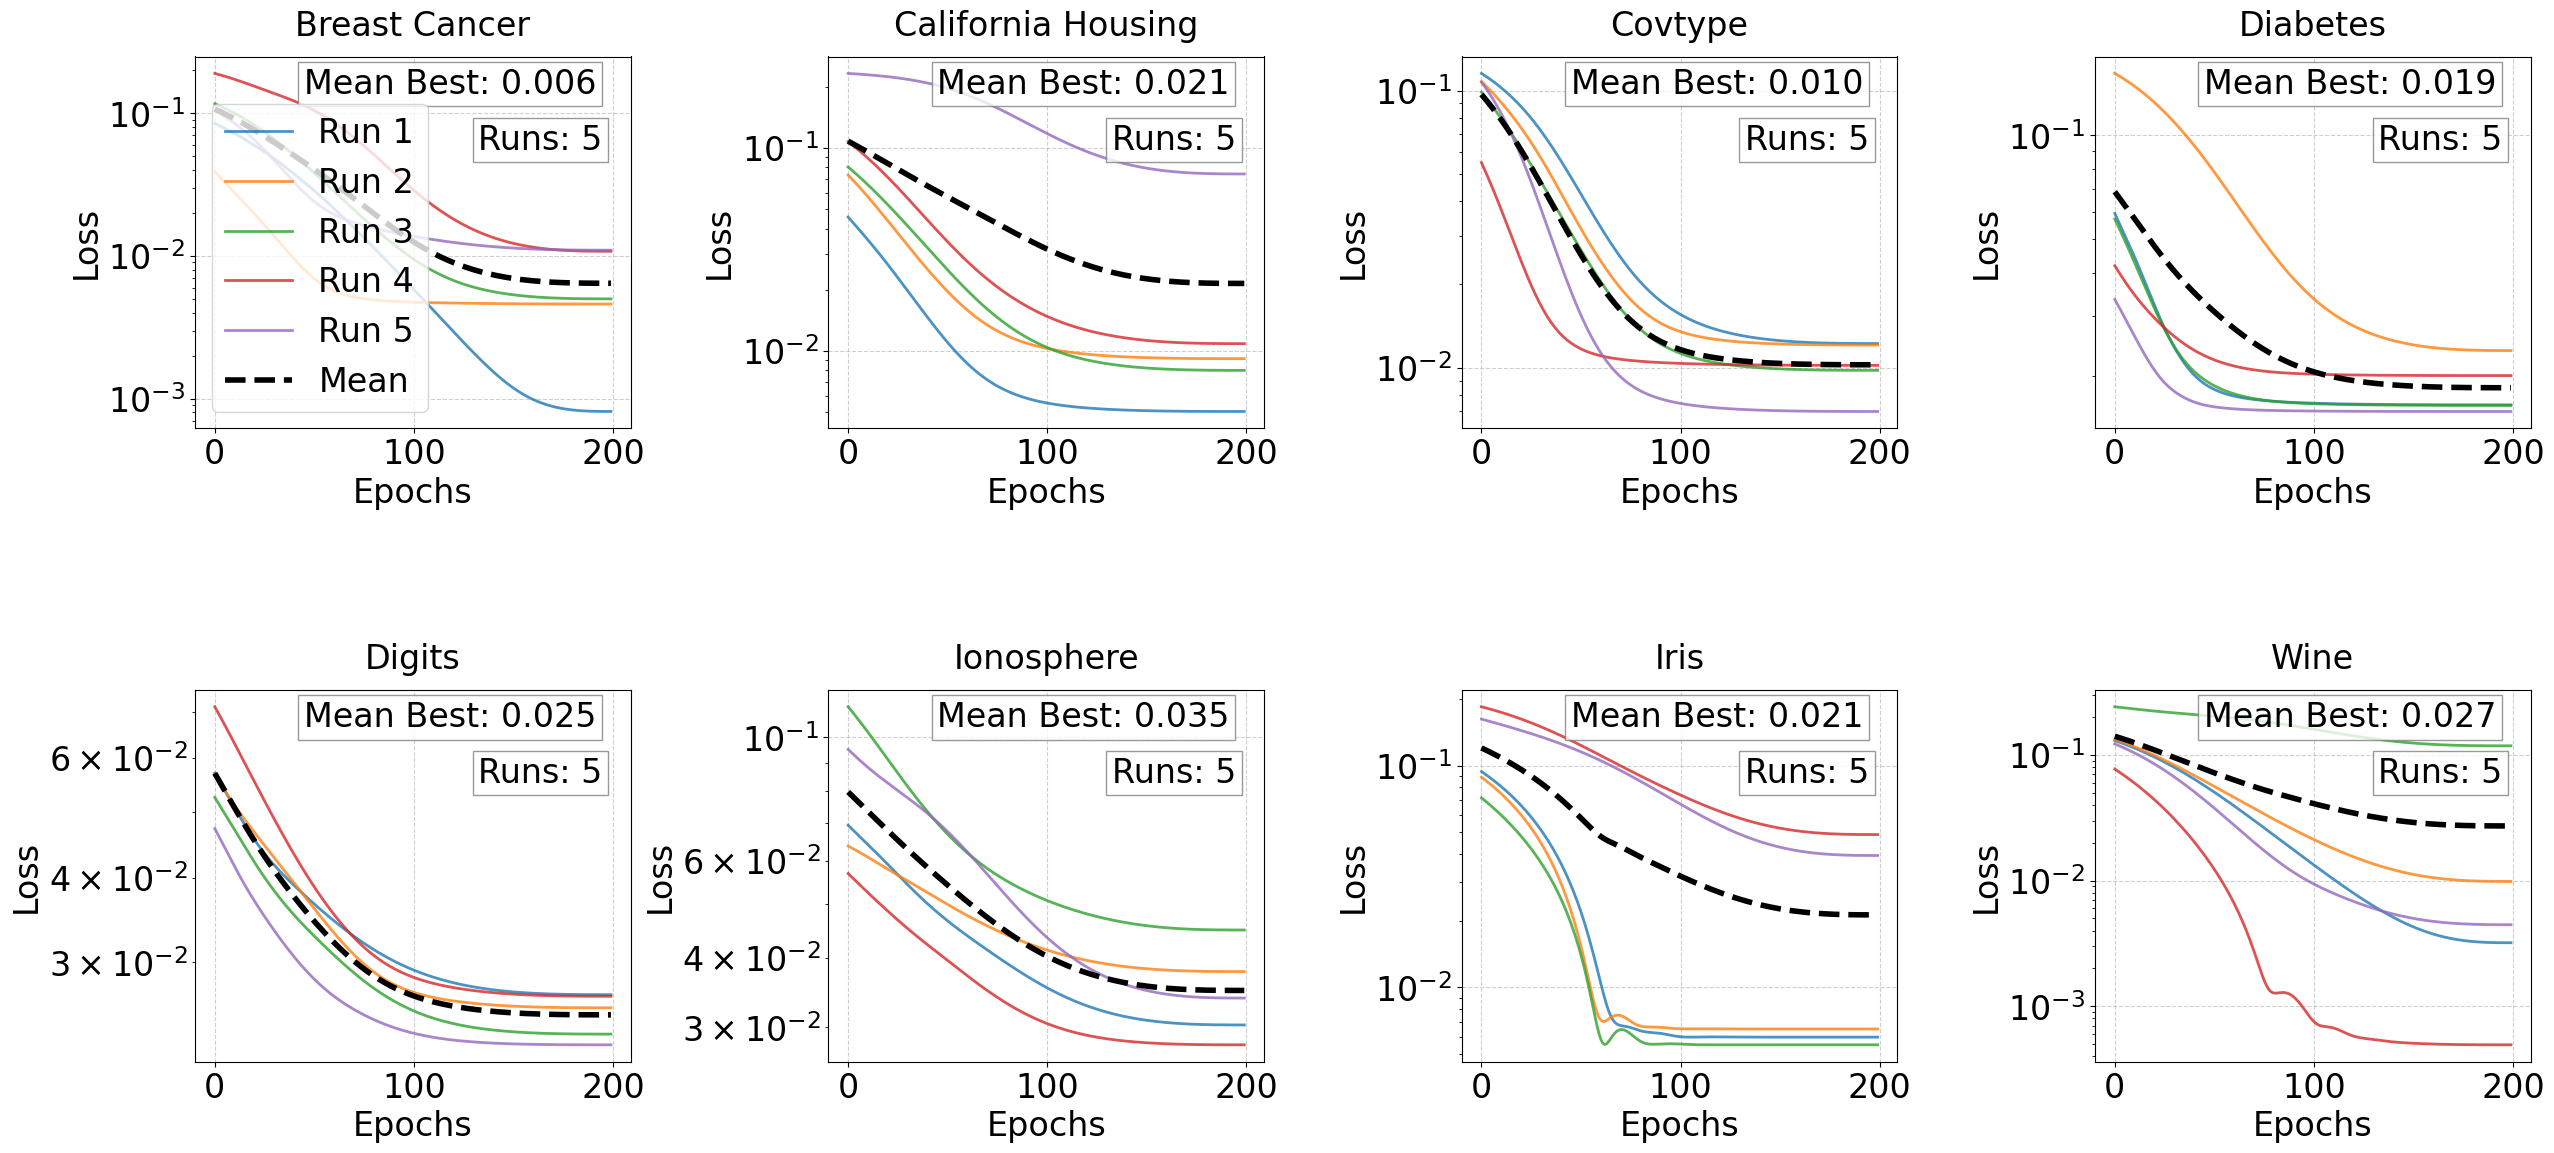

In [ ]:
plot_results(all_results, number_of_runs=5, fig_name=f"fig_schmidt_circuit_for_sample")
